In [24]:
import zCurve as z
import csv
import cv2
import os
import numpy as np
import pandas as pd
import glob
import json 
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [215]:
def calculateMortonFromList_with_zCurve(values):
    # Cap floating point numbers to one decimal place and convert to integers
    int_values = [int(round(value, 1) * 10) for value in values]
    value = z.interlace(*int_values, dims=len(int_values))
    return value 

In [57]:
seq_path = '../datasets/smirk/child/9jJxC2pmKULPI8arYKQ5O/'
config_path = '../config.json'

In [58]:
with open(config_path, 'r') as _f:
    config = json.load(_f)

In [59]:
config

{'General': {'device': 'cuda:0', 'epochs': 400, 'batch_size': 24},
 'mlnet_input_size': [640, 480],
 'mlnet_model_path': './model_paths/mlnet/mlnet_25.pth',
 'mlnet_pred_saving_path': '',
 'attention_grid': {'width': 53,
  'height': 120,
  'grid_left_top_coord': [[128, 216],
   [181, 216],
   [234, 216],
   [352, 216],
   [405, 216],
   [458, 216]],
  'threshold': 0.2},
 'Dataset': {'name': 'smirk',
  'transforms': {'image_mean': [0.485, 0.456, 0.406],
   'image_std': [0.229, 0.224, 0.225]}},
 'Morton_Detect': {'cell_ranges': {'0': [2.7e-07, 5.5e-07],
   '1': [6.5e-07, 1e-06],
   '2': [1.44e-06, 1.84e-06],
   '3': [3.1e-06, 3.5e-06],
   '4': [6.3e-06, 6.8e-06],
   '5': [1.28e-05, 1.34e-05]}}}

In [39]:
#sorted(os.listdir(seq_path))

In [19]:
rgb_path = os.path.join(seq_path,'cam000200.png')

In [256]:
yolo = YOLO("yolo11m.pt")  # load an official model
# Predict with the model
#results = yolo([rgb_path, os.path.join(seq_path,'cam000202.png')])
results = yolo.predict(rgb_path, verbose=False)

In [257]:
for result in results:
    # result.show()
    result = result.boxes.cpu().numpy()
    xyxy = result.xyxy.astype(np.int64)
    xywh = result.xywh.astype(np.int64)
    yolo_start_point = [xyxy[0][0], xyxy[0][1]]
    yolo_end_point = [xyxy[0][2], xyxy[0][3]]

In [258]:
print(result)

ultralytics.engine.results.Boxes object with attributes:

cls: array([          0], dtype=float32)
conf: array([    0.84206], dtype=float32)
data: array([[     227.12,      248.84,      248.74,      320.68,     0.84206,           0]], dtype=float32)
id: None
is_track: False
orig_shape: (480, 752)
shape: (1, 6)
xywh: array([[     237.93,      284.76,      21.624,       71.84]], dtype=float32)
xywhn: array([[    0.31639,     0.59325,    0.028756,     0.14967]], dtype=float32)
xyxy: array([[     227.12,      248.84,      248.74,      320.68]], dtype=float32)
xyxyn: array([[    0.30202,     0.51841,     0.33077,     0.66808]], dtype=float32)


In [130]:
yolo_end_point

[248, 320]

In [196]:
rgb_cv2 = cv2.imread(rgb_path)

In [197]:
attention_cells_start_cord = config['attention_grid']['grid_left_top_coord'] # top-left point of bbox
attention_cells_start_cord = np.array(attention_cells_start_cord)
for i in attention_cells_start_cord:
    print(i)
#attention_cells_start_cord[0] + np.array([1,1])
#print(sum(attention_cells_start_cord[0], [1,1]))

[128 216]
[181 216]
[234 216]
[352 216]
[405 216]
[458 216]


In [198]:
attention_cell_width = config['attention_grid']['width']
attention_cell_height = config['attention_grid']['height']

In [199]:
attention_cells_end_cord = [start_piont + np.array([attention_cell_width, attention_cell_height]) for start_piont in attention_cells_start_cord]
attention_cells_end_cord

[array([181, 336]),
 array([234, 336]),
 array([287, 336]),
 array([405, 336]),
 array([458, 336]),
 array([511, 336])]

In [200]:
for i in range(len(attention_cells_start_cord)):
    rgb_cell_draw = cv2.rectangle(rgb_cv2, attention_cells_start_cord[i], attention_cells_end_cord[i], (0,255,0), 1)

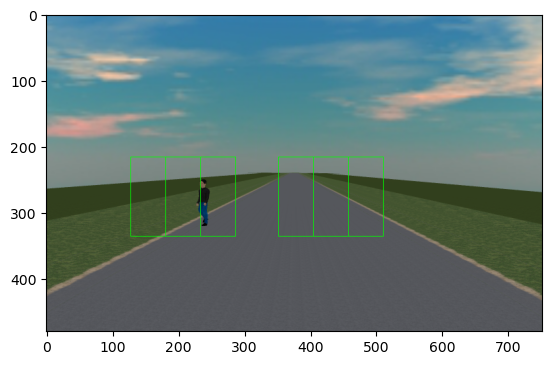

In [201]:
plt.imshow(cv2.cvtColor(rgb_cell_draw, cv2.COLOR_BGR2RGB))

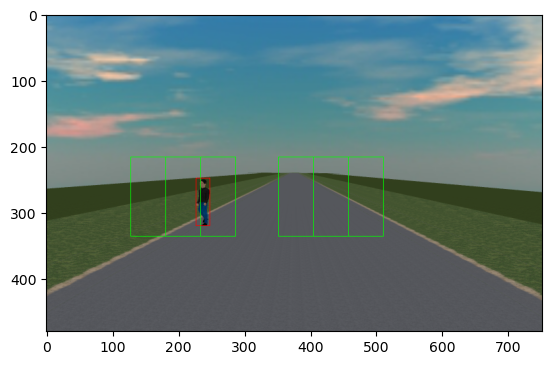

In [202]:
rgb_cell_yolo_draw = cv2.rectangle(rgb_cell_draw, yolo_start_point, yolo_end_point, (0,0,255), 1)
plt.imshow(cv2.cvtColor(rgb_cell_yolo_draw, cv2.COLOR_BGR2RGB))

In [203]:
def overlap(cell_cord, yolo_cord): # [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    x_left = max(cell_cord[0], yolo_cord[0])
    x_right = min(cell_cord[2], yolo_cord[2])
    y_top = max(cell_cord[1], yolo_cord[1])
    y_bottom = min(cell_cord[3], yolo_cord[3])

    if x_right < x_left or y_bottom < y_top:
        return 0, 0, 0, 0, 0
    overlap_area = (x_right - x_left) * (y_bottom - y_top)
    return overlap_area, x_left, y_top, x_right, y_bottom

In [204]:
print(yolo_start_point)
print(yolo_end_point)
yolo_cord = np.concatenate([yolo_start_point, yolo_end_point])
print(yolo_cord)

[227, 248]
[248, 320]
[227 248 248 320]


In [205]:
print(attention_cells_start_cord)
print(attention_cells_end_cord)

[[128 216]
 [181 216]
 [234 216]
 [352 216]
 [405 216]
 [458 216]]
[array([181, 336]), array([234, 336]), array([287, 336]), array([405, 336]), array([458, 336]), array([511, 336])]


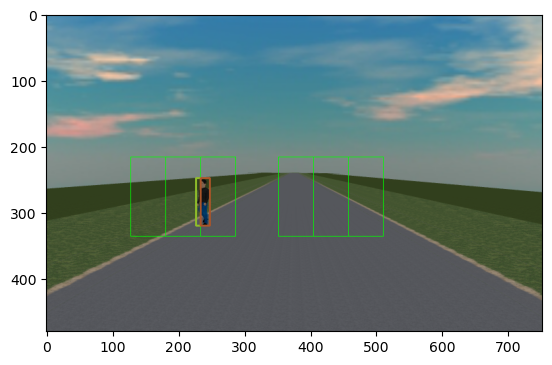

In [211]:
for i in range(len(attention_cells_start_cord)):
    cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
    
    overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)
    color = list(np.random.random(size=3) * 256)
    rgb_overlap = cv2.rectangle(rgb_cell_yolo_draw, [x_left, y_top], [x_right, y_bottom], color, 2)
plt.imshow(cv2.cvtColor(rgb_overlap, cv2.COLOR_BGR2RGB))

# Propotion

In [235]:
input_zcurve = np.zeros(6)
for i in range(len(attention_cells_start_cord)):
    cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
    overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)

    yolo_bbox_area = (yolo_cord[2] - yolo_cord[0]) * (yolo_cord[3] - yolo_cord[1])
    
    if overlap_area > 0:
        input_zcurve[i] = overlap_area / yolo_bbox_area
    
    print(overlap_area, x_left, y_top, x_right, y_bottom)
print(input_zcurve)

0 0 0 0 0
504 227 248 234 320
1008 234 248 248 320
0 0 0 0 0
0 0 0 0 0
0 0 0 0 0
[          0     0.33333     0.66667           0           0           0]


In [238]:
morton_rgb = calculateMortonFromList_with_zCurve(input_zcurve)
morton_rgb

16774

### Combine everything to process all images in a sequence. 

In [272]:
morton_codes = []
for anno_frame in sorted(glob.glob(os.path.join(seq_path, '*.labels.png'))):
    rgb_frame = anno_frame.replace('.labels.png', '.png')
    results = yolo.predict(rgb_frame, verbose=False)
    for result in results:
        # result.show()
        result = result.boxes.cpu().numpy()
        xyxy = result.xyxy.astype(np.int64)
        xywh = result.xywh.astype(np.int64)
        yolo_start_point = [xyxy[0][0], xyxy[0][1]]
        yolo_end_point = [xyxy[0][2], xyxy[0][3]]
    
    rgb_cv2 = cv2.imread(rgb_frame)
    for i in range(len(attention_cells_start_cord)):
        rgb_cell_draw = cv2.rectangle(rgb_cv2, attention_cells_start_cord[i], attention_cells_end_cord[i], (0,255,0), 1)    
    rgb_cell_yolo_draw = cv2.rectangle(rgb_cell_draw, yolo_start_point, yolo_end_point, (0,0,255), 1)
    
    result_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_yolo')
    if not os.path.exists(os.path.dirname(result_path)):
        os.makedirs(os.path.dirname(result_path))
    cv2.imwrite(result_path, rgb_cell_yolo_draw)

    yolo_cord = np.concatenate([yolo_start_point, yolo_end_point])

    input_zcurve = np.zeros(6)
    for i in range(len(attention_cells_start_cord)):
        cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)
        yolo_bbox_area = (yolo_cord[2] - yolo_cord[0]) * (yolo_cord[3] - yolo_cord[1])
         
        color = list(np.random.random(size=3) * 256)
        rgb_overlap = cv2.rectangle(rgb_cell_yolo_draw, [x_left, y_top], [x_right, y_bottom], color, 2)
        if overlap_area > 0:
            input_zcurve[i] = overlap_area / yolo_bbox_area
    
    overlap_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_overlap')
    if not os.path.exists(os.path.dirname(overlap_path)):
        os.makedirs(os.path.dirname(overlap_path))
    cv2.imwrite(overlap_path, rgb_overlap)

    morton_rgb = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_rgb})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/morton_codes_yolo_proportion.csv', sep=';', index=False)

### Read the csv jsut saved and plot

In [288]:
morton_codes_yolo_proportion = pd.read_csv('../outputs/morton_codes_yolo_proportion.csv', sep=';')
morton_codes_yolo_proportion = morton_codes_yolo_proportion.to_numpy()

In [295]:
mortons_seq = []
for i in range(len(morton_codes_yolo_proportion)):
    frame, morton = morton_codes_yolo_proportion[i]
    mortons_seq.append(morton)
print(mortons_seq)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 2048, 2080, 131072, 131104, 133120, 133152, 133152, 8388608, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8390656, 8388656, 134192, 198656, 198656, 196656, 197632, 4196352, 4194352, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4195328, 4194328, 4194328, 4194816, 67096, 98328, 98816, 34328, 2098176, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097664, 2097160, 33288, 33280, 32776, 520, 

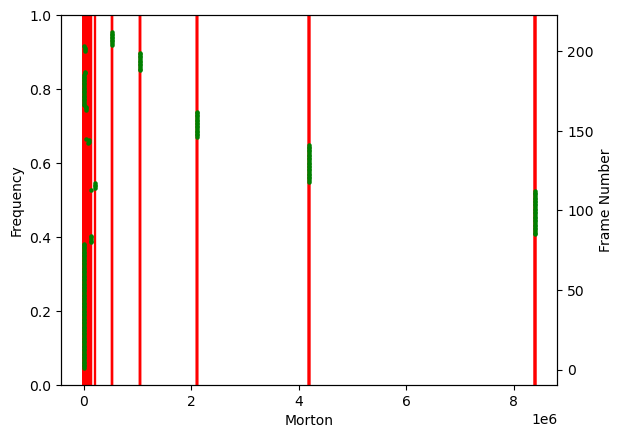

In [296]:
_, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")

# Area

In [297]:
morton_codes = []
for anno_frame in sorted(glob.glob(os.path.join(seq_path, '*.labels.png'))):
    rgb_frame = anno_frame.replace('.labels.png', '.png')
    results = yolo.predict(rgb_frame, verbose=False)
    for result in results:
        # result.show()
        result = result.boxes.cpu().numpy()
        xyxy = result.xyxy.astype(np.int64)
        xywh = result.xywh.astype(np.int64)
        yolo_start_point = [xyxy[0][0], xyxy[0][1]]
        yolo_end_point = [xyxy[0][2], xyxy[0][3]]
    
    rgb_cv2 = cv2.imread(rgb_frame)
    for i in range(len(attention_cells_start_cord)):
        rgb_cell_draw = cv2.rectangle(rgb_cv2, attention_cells_start_cord[i], attention_cells_end_cord[i], (0,255,0), 1)    
    rgb_cell_yolo_draw = cv2.rectangle(rgb_cell_draw, yolo_start_point, yolo_end_point, (0,0,255), 1)
    
    # result_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_yolo')
    # if not os.path.exists(os.path.dirname(result_path)):
    #     os.makedirs(os.path.dirname(result_path))
    # cv2.imwrite(result_path, rgb_cell_yolo_draw)

    yolo_cord = np.concatenate([yolo_start_point, yolo_end_point])

    input_zcurve = np.zeros(6)
    for i in range(len(attention_cells_start_cord)):
        cell_cord = np.concatenate([attention_cells_start_cord[i], attention_cells_end_cord[i]], axis=0)
        overlap_area, x_left, y_top, x_right, y_bottom = overlap(cell_cord, yolo_cord)
        yolo_bbox_area = (yolo_cord[2] - yolo_cord[0]) * (yolo_cord[3] - yolo_cord[1])
         
        color = list(np.random.random(size=3) * 256)
        rgb_overlap = cv2.rectangle(rgb_cell_yolo_draw, [x_left, y_top], [x_right, y_bottom], color, 2)
        if overlap_area > 0:
            input_zcurve[i] = overlap_area     
    # overlap_path = rgb_frame.replace('datasets/smirk', 'outputs/smirk_overlap')
    # if not os.path.exists(os.path.dirname(overlap_path)):
    #     os.makedirs(os.path.dirname(overlap_path))
    # cv2.imwrite(overlap_path, rgb_overlap)

    morton_rgb = calculateMortonFromList_with_zCurve(input_zcurve)
    morton_codes.append({'frame': rgb_frame, 'morton': morton_rgb})

morton_codes = pd.DataFrame(morton_codes, columns=['frame', 'morton'])
morton_codes.to_csv('../outputs/morton_codes_yolo_area.csv', sep=';', index=False)

### Read the csv jsut saved and plot

In [298]:
morton_codes_yolo_area = pd.read_csv('../outputs/morton_codes_yolo_area.csv', sep=';')
morton_codes_yolo_area = morton_codes_yolo_area.to_numpy()

In [312]:
mortons_seq = []
for i in range(len(morton_codes_yolo_area)):
    frame, morton = morton_codes_yolo_area[i]
    mortons_seq.append(int(morton) / 1000000000000000000000000000)
print(mortons_seq)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.854679864549048e-10, 3.689362891980407e-08, 3.7469951133113906e-08, 2.3611832414348227e-06, 2.3611923915711344e-06, 2.39807687251929e-06, 0.0001511157364590628, 0.0001511163129198151, 0.00015115262994937488, 0.00015115319754369978, 0.00015115319754369978, 0.00015347691069326347, 0.00015347691069326347, 0.00015115320654866512, 0.00015115262094001042, 0.00015115319754369978, 0.00015347691984123456, 0.00015351381332934764, 0.0001535138043221484, 0.0001534769197004976, 0.0001534769197004976, 0.00015347748729698665, 0.00015347691984339925, 0.0001534769108340015, 0.00015115319754366543, 0.00015347691984339925, 0.009

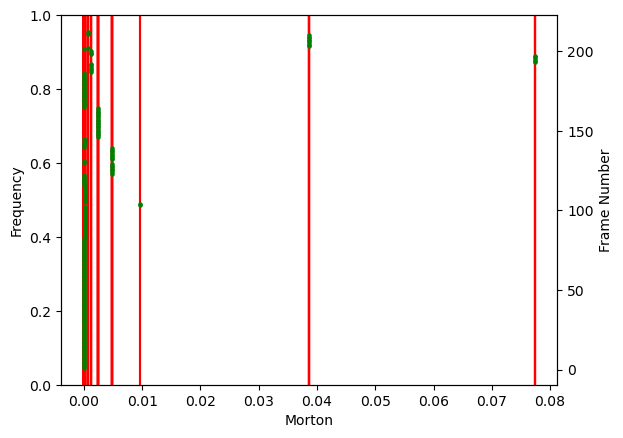

In [313]:
_, ax1 = plt.subplots()
ax1.set_xlabel("Morton")
ax1.set_ylabel("Frequency")
ax1.set_ylim((0, 1))
ax1.eventplot(mortons_seq, orientation='horizontal', colors="red",lineoffsets=0.5)

ax2 = ax1.twinx()
for frame_id in range(len(mortons_seq)):
    x=mortons_seq[frame_id]
    y=frame_id+1
    ax2.scatter(x, y, s=5, color='green')
    ax2.set_ylabel("Frame Number")